In [1]:
import sys
import os
import requests
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from models.mae import models_mae
#from models.mae import models_mae_2
from skimage import draw
import math
import torch.nn.functional as F
import torch.nn as nn

/p/project/hai_dm4eo/wang36/jupyter/kernels/wang36_kernel/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# define the utils

def show_image(id,image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    #plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    image = torch.clip(image * 255, 0, 255).int()
    plt.imshow(image)
    plt.axis('off')
    #plt.savefig('utils/s2_0000004_{}.pdf'.format(title), bbox_inches='tight', format='pdf')
    plt.title(title, fontsize=16)
    
    #img = Image.fromarray(image.numpy().astype('uint8'),'RGB')
    #img.save('utils/visualize/s1_{:07d}_{}.png'.format(id,title))
    
    return

def prepare_model(chkpt_dir, in_chans=2, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)(in_chans=in_chans,feature='raw',hog_norm=False)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(id, img_s, model):
    x = img_s # N,W,H,C
    x_d = x

    # run MAE
    loss, pred, mask, target = model(x.float(),mask_ratio=0.70)

    target_1d = model.patchify(target)
    mean = target_1d.mean(dim=-1, keepdim=True)
    var = target_1d.var(dim=-1, keepdim=True)  
    pred = pred * (var + 1.e-6)**.5 + mean
    # pred2 unpatchify TBD
    pred = pred.detach()
    pred = model.unpatchify(pred)
    pred = torch.einsum('nchw->nhwc', pred).detach().cpu()
    y = torch.stack((pred[0,:,:,0],pred[0,:,:,1],pred[0,:,:,1]),-1)
    

    target = target.detach().cpu().numpy()
    t0 = target[0,0]
    t1 = target[0,1]
    t = torch.Tensor(np.stack((t0,t1,t1),-1))
    

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *2)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)
    x_d = torch.einsum('nchw->nhwc', x_d)
    

    chs = []
    for ch in range(2):
        im = x[:,:,:,ch]
        #p1 = torch.quantile(im,0.01)
        #p99 = torch.quantile(im,0.99)
        #im = torch.clip(im,p1,p99)
        im = (im - im.min()) / (im.max() - im.min())
        chs.append(im)
    x = torch.stack(chs,-1)

    x = torch.stack((x[:,:,:,0],x[:,:,:,1],x[:,:,:,1]),-1)
    mask = torch.stack((mask[:,:,:,0],mask[:,:,:,1],mask[:,:,:,1]),-1)
    
    
    chs = []
    for ch in range(3):
        im = y[:,:,ch]
        
        p1 = torch.quantile(im,0.01)
        #p1 = torch.quantile(im,0.25)
        p99 = torch.quantile(im,0.99)
        im = torch.clip(im,p1,p99)
        im = (im - p1) / (p99 - p1)
        #im = im / 1.5
        chs.append(im)
    y = torch.stack(chs,-1)  
    
    chs = []
    for ch in range(3):
        im = t[:,:,ch]
        p1 = torch.quantile(im,0.01)
        p99 = torch.quantile(im,0.99)
        im = torch.clip(im,p1,p99)
        im = (im - p1) / (p99 - p1)
        #im = im / 1.5
        chs.append(im)
    t = torch.stack(chs,-1)
    
    
    
    # masked image
    im_masked = x[0] * (1 - mask[0])

    # HOG reconstruction pasted with visible patches
    im_paste = t * (1 - mask[0]) + y * mask[0]

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 6, 1)
    show_image(id, x[0], "raw")

    plt.subplot(1, 6, 2)
    show_image(id,im_masked, "masked")
    

    plt.subplot(1, 6, 3)
    #show_image(y, "reconstruction")
    show_image(id,im_paste, "reconstruction image")

    plt.subplot(1, 6, 4)
    show_image(id,t, "target image")  
    
    #plt.savefig('utils/visualize/s1_{:07d}_all.pdf'.format(id), bbox_inches='tight', format='pdf')

    plt.show()

In [3]:
#chkpt_dir = '/p/project/hai_ssl4eo/wang_yi/MAE-MFP/src/benchmark/pretrain_ssl/checkpoints/mae_vits16_hog_B13/checkpoint-99.pth'
#chkpt_dir = '/p/project/hai_ssl4eo/wang_yi/MAE-MFP/src/benchmark/pretrain_ssl/checkpoints/mae_vitl16_hog-indices_B13/checkpoint-99.pth'
chkpt_dir = '/p/project/hai_ssl4eo/wang_yi/MAE-MFP/src/benchmark/pretrain_ssl/checkpoints/mae_vits16_raw_B2/checkpoint-99.pth'
model = prepare_model(chkpt_dir, 2, 'mae_vit_small_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


In [4]:
from datasets.SSL4EO.ssl4eo_dataset_lmdb import LMDBDataset,random_subset
from cvtorchvision import cvtransforms

lmdb_file_s2 = '/p/project/hai_dm4eo/wang_yi/data/251k_ms.lmdb'
lmdb_file_s1 = '/p/project/hai_dm4eo/wang_yi/data/251k_sar.lmdb'

transform_train = cvtransforms.Compose([
        #cvtransforms.RandomResizedCrop(224, scale=(0.2, 1.0)),  # 3 is bicubic
        #cvtransforms.RandomHorizontalFlip(),
        #cvtransforms.Resize(224),
        cvtransforms.CenterCrop(224),
        cvtransforms.ToTensor(),
        ])

dataset_train = LMDBDataset(
            lmdb_file=lmdb_file_s1,
            is_slurm_job=False,
            s1_transform=transform_train,
            mode=['s1'],
            dtype='float32',
        )

#dataset_train = random_subset(dataset_train,frac=1,seed=42)
#dataloader = torch.utils.data.DataLoader(dataset_train,shuffle=False,batch_size=1)

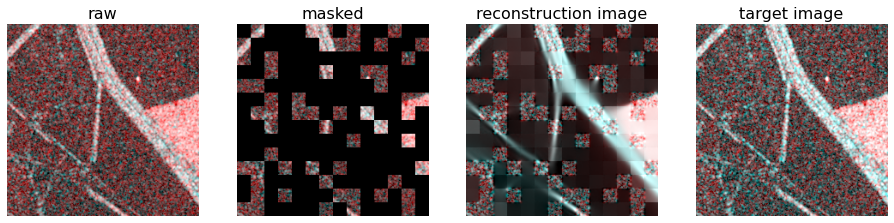

In [8]:
id = 5
img_in = dataset_train[id].unsqueeze(0)
run_one_image(id, img_in, model)